In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
import os
import warnings

warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath(".."))

In [4]:
# Logging
import logging

# Type-hints
from typing import Sequence

# IO
from pathlib import Path

# Datasets
import pandas as pd
import dataset as nlp_dataset

# Text
import string
import re 
import nltk
import wordcloud

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from utils import io_utils, log_utils, plot_utils
from collections import Counter

import importlib
importlib.reload(logging)

logger = logging.getLogger()
log_utils.setup_logging()

# CONSTANTS & HYPERPARAMETERS

In [5]:
DO_REMOVE_STOPWORDS   = False

MODELS_DIR            = Path("../model")
DATA_DIR              = Path("../data")

# DATA

## LOAD THE DATASET + CLEAN

## SET ASIDE VALIDATION/TEST DATASET

In [6]:
# Create/load dataframe

DF_PATH = DATA_DIR/"huggingface_imdb_sentiment_df.p"

if DF_PATH.exists():
    logger.debug(f"Loading dataset from file: '{DF_PATH}'")
    df = pd.read_pickle(DF_PATH)
else:
    # Create train & test datasets
    df = nlp_dataset.create_dataframe(dataset_name="imdb", dataset_split=None)
    df = nlp_dataset.preprocess_dataframe(
        df,
        model_type            = "sklearn",
        tokenizer             = None,
        stemmer               = None,
        do_remove_stopwords   = DO_REMOVE_STOPWORDS,
        save_path             = DF_PATH
    )

# Add original reviews' token length column
# NOTE: Using a tokenizer might be more precise, but need to take punctuation into account
tokened_text_len = [len(text.split()) for text in df["review"]]

# Add pre-processed texts' token length column
tokened_preprocessed_text_len = [len(l) for l in df.tokened]

df.insert(df.columns.get_loc("tokened")+1, column="tokened_preprocessed_len", value=tokened_preprocessed_text_len)
df.insert(df.columns.get_loc("tokened")+1, column="tokened_len", value=tokened_text_len)

logger.debug(f"Splitting dataset into train & test (25000 each")
df_train, df_test = df[:25000], df[25000:]

2022-07-12 : 21:01:14,72 DEBUG    [ root - <module>: 6 ] Loading dataset from file: '..\data\huggingface_imdb_sentiment_df.p'
2022-07-12 : 21:01:15,886 DEBUG    [ root - <module>: 30 ] Splitting dataset into train & test (25000 each


## Analyze data with descriptive statistics

### Train set

In [7]:
df_train.head(3)

,review,preprocessed_text,tokened,tokened_len,tokened_preprocessed_len,label,label_name
0,Bromwell High is a cartoon comedy. It ran at t...,bromwell high is a cartoon comedy it ran at th...,"[bromwell, high, is, a, cartoon, comedy, it, r...",140,141,1,POSITIVE
1,Homelessness (or Houselessness as George Carli...,homelessness or houselessness as george carlin...,"[homelessness, or, houselessness, as, george, ...",428,439,1,POSITIVE
2,Brilliant over-acting by Lesley Ann Warren. Be...,brilliant over acting by lesley ann warren bes...,"[brilliant, over, acting, by, lesley, ann, war...",147,150,1,POSITIVE


In [8]:
# Info
df_train[["review", "preprocessed_text", "tokened_len", "tokened_preprocessed_len", "label"]].describe(include="all")

,review,preprocessed_text,tokened_len,tokened_preprocessed_len,label
count,25000,25000,25000.000000,25000.000000,25000.00000
unique,24904,24901,NaN,NaN,NaN
top,You do realize that you've been watching the E...,you do realize that you ve been watching the e...,NaN,NaN,NaN
freq,3,3,NaN,NaN,NaN
mean,NaN,NaN,233.787200,238.236480,0.50000
std,NaN,NaN,173.733032,176.808608,0.50001
min,NaN,NaN,10.000000,10.000000,0.00000
25%,NaN,NaN,127.000000,130.000000,0.00000
50%,NaN,NaN,174.000000,178.000000,0.50000
75%,NaN,NaN,284.000000,289.000000,1.00000


### Test set

In [9]:
# First few examples
df_test.head(3)

,review,preprocessed_text,tokened,tokened_len,tokened_preprocessed_len,label,label_name
25000,I went and saw this movie last night after bei...,i went and saw this movie last night after bei...,"[i, went, and, saw, this, movie, last, night, ...",152,153,1,POSITIVE
25001,Actor turned director Bill Paxton follows up h...,actor turned director bill paxton follows up h...,"[actor, turned, director, bill, paxton, follow...",344,353,1,POSITIVE
25002,As a recreational golfer with some knowledge o...,as a recreational golfer with some knowledge o...,"[as, a, recreational, golfer, with, some, know...",244,247,1,POSITIVE


In [10]:
df_train[["review", "preprocessed_text", "tokened_len", "tokened_preprocessed_len", "label"]].describe(include="all")

,review,preprocessed_text,tokened_len,tokened_preprocessed_len,label
count,25000,25000,25000.000000,25000.000000,25000.00000
unique,24904,24901,NaN,NaN,NaN
top,You do realize that you've been watching the E...,you do realize that you ve been watching the e...,NaN,NaN,NaN
freq,3,3,NaN,NaN,NaN
mean,NaN,NaN,233.787200,238.236480,0.50000
std,NaN,NaN,173.733032,176.808608,0.50001
min,NaN,NaN,10.000000,10.000000,0.00000
25%,NaN,NaN,127.000000,130.000000,0.00000
50%,NaN,NaN,174.000000,178.000000,0.50000
75%,NaN,NaN,284.000000,289.000000,1.00000


## Visualize data

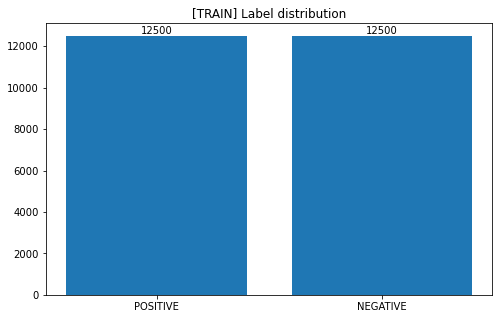

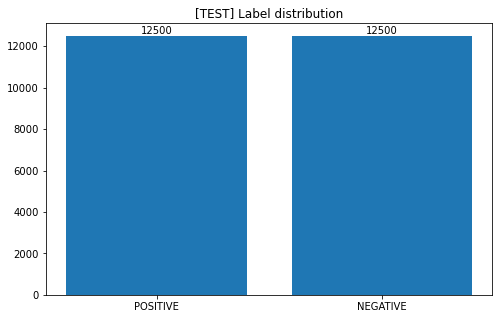

In [11]:
# Label distribution
fig1 = plot_utils.target_label_distribution(df_train, target_col="label_name", title="[TRAIN] Label distribution", figsize=(8, 5))
fig2 = plot_utils.target_label_distribution(df_test, target_col="label_name", title="[TEST] Label distribution", figsize=(8, 5))

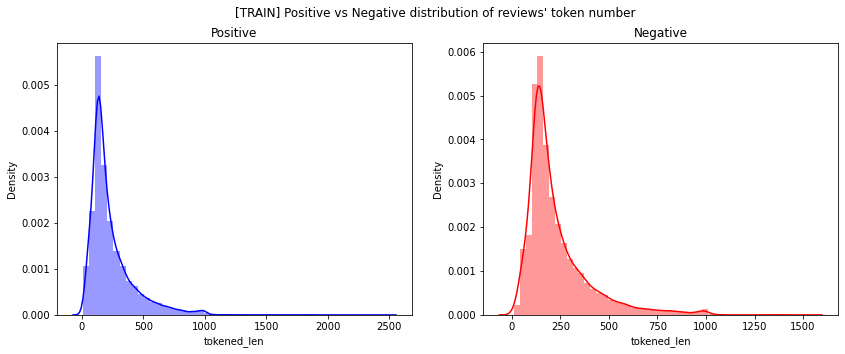

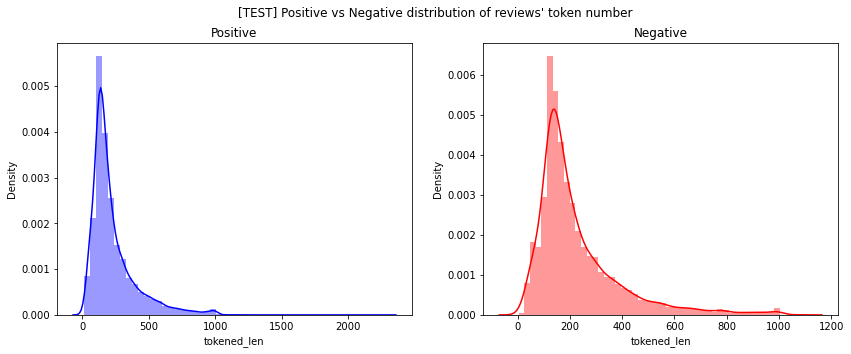

In [12]:
# Positive vs negative number of tokens distribution
# NOTE: "tokened_len" is the length of pre-processed text tokens

df_train_pos = df_train[df_train.label_name == "POSITIVE"]
df_train_neg = df_train[df_train.label_name == "NEGATIVE"]

plot_utils.pos_vs_negative_distribution(
    df_pos    = df_train_pos,
    df_neg    = df_train_neg,
    title     = "[TRAIN] Positive vs Negative distribution of reviews' token number",
    figsize   = (14, 5)
)

df_test_pos = df_test[df_test.label_name == "POSITIVE"]
df_test_neg = df_test[df_test.label_name == "NEGATIVE"]

plot_utils.pos_vs_negative_distribution(
    df_pos    = df_test_pos,
    df_neg    = df_test_neg,
    title     = "[TEST] Positive vs Negative distribution of reviews' token number",
    figsize   = (14, 5)
)

In [13]:
# Word cloud (top 1000)
input_col         = "review"
df_train_wc       = plot_utils.gen_wordcloud(text=' '.join(df_train[input_col]), stopwords=nlp_dataset.STOPWORDS)
df_test_wc        = plot_utils.gen_wordcloud(text=' '.join(df_test[input_col]), stopwords=nlp_dataset.STOPWORDS)

df_train_pos_wc   = plot_utils.gen_wordcloud(text=' '.join(df_train_pos[input_col]), stopwords=nlp_dataset.STOPWORDS)
df_train_neg_wc   = plot_utils.gen_wordcloud(text=' '.join(df_train_neg[input_col]), stopwords=nlp_dataset.STOPWORDS)

df_test_pos_wc    = plot_utils.gen_wordcloud(text=' '.join(df_test_pos[input_col]), stopwords=nlp_dataset.STOPWORDS)
df_test_neg_wc    = plot_utils.gen_wordcloud(text=' '.join(df_test_neg[input_col]), stopwords=nlp_dataset.STOPWORDS)

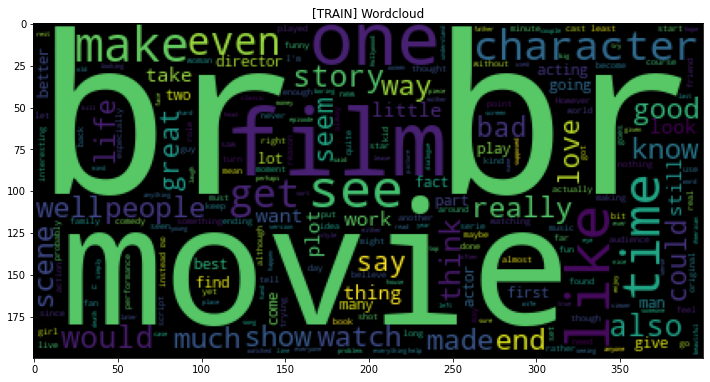

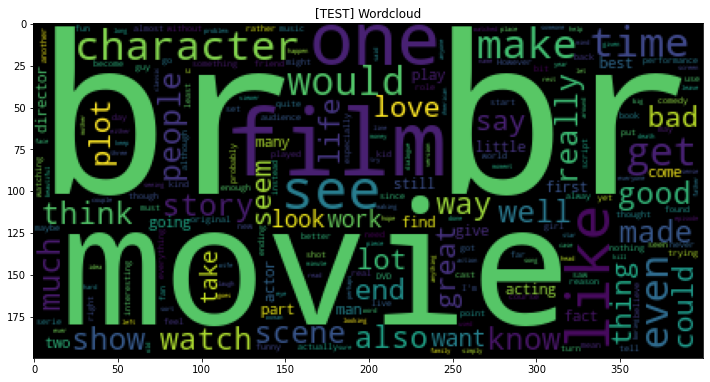

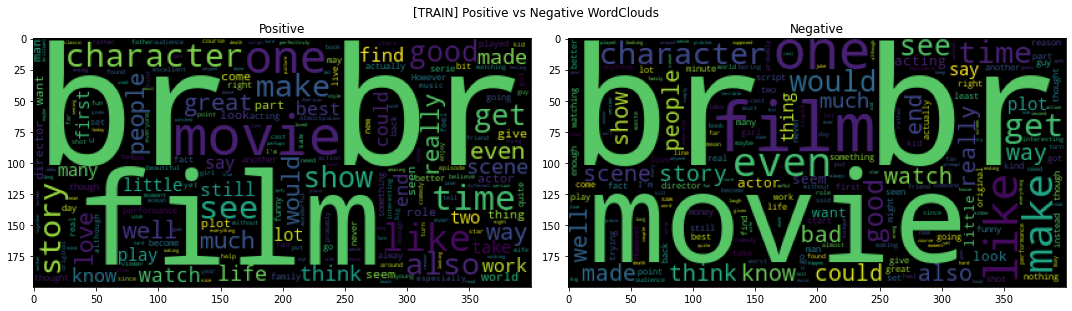

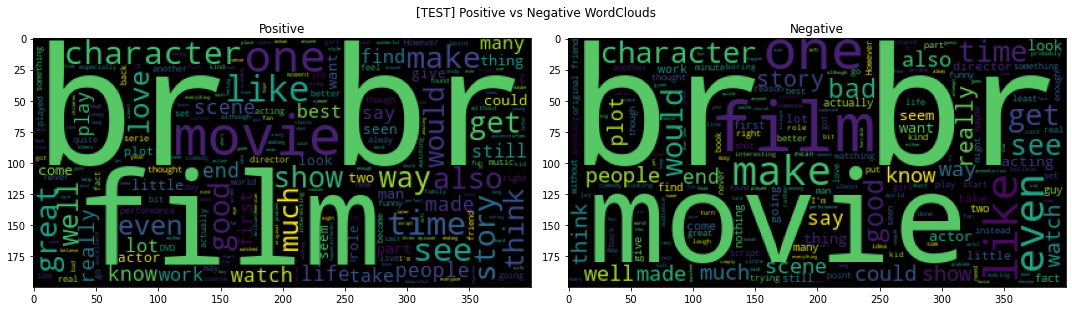

In [14]:
plot_utils.show_wordcloud(
    wc        = df_train_wc,
    title     = "[TRAIN] Wordcloud",
    figsize   = (12, 8)
)

plot_utils.show_wordcloud(
    wc        = df_test_wc,
    title     = "[TEST] Wordcloud",
    figsize   = (12, 8)
)

plot_utils.show_duo_wordcloud(
    wc1       = df_train_pos_wc,
    wc2       = df_train_neg_wc,
    title1    = "Positive",
    title2    = "Negative",
    suptitle  = "[TRAIN] Positive vs Negative WordClouds",
    figsize   = (15, 8)
)

plot_utils.show_duo_wordcloud(
    wc1       = df_test_pos_wc,
    wc2       = df_test_neg_wc,
    title1    = "Positive",
    title2    = "Negative",
    suptitle  = "[TEST] Positive vs Negative WordClouds",
    figsize   = (15, 8)
)

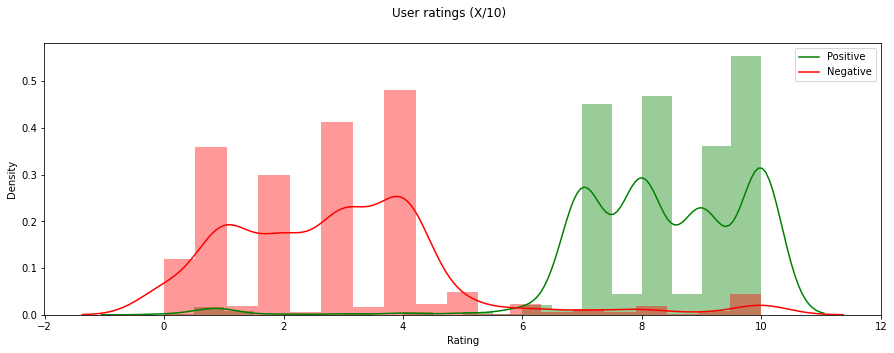

In [15]:
# User ratings (not sure where to go with this yet)
# user_ratings_train = [re.search(r"\d*\.*\d+/10", r) for r in df_train.review]
# user_ratings_test  = [re.search(r"\d*\.*\d+/10", r) for r in df_test.review]
user_ratings = [re.search(r"\d*\.*\d+/10", r) for r in df.review]

# Making sure regex works for finding user rating (X/10) works
user_ratings = [(i, ur.group(), float(re.findall("([0-9]*\.?[0-9]*)/10", ur.group())[0]), l) for i, (ur, l) in enumerate(zip(user_ratings, df.label_name)) if ur is not None]

# Outliers
outliers = [(idx, rating, score, label) for idx, rating, score, label in user_ratings if score > 10]

# Checking user rating (found in text) against label
# # Option 1: Normalize outlier scores to max (10)
# ratings_labels = [(score if score <= 10 else 10, label) for idx, rating, score, label in user_ratings]

# Option 2: Ignore outliers
ratings_labels = [(score, label) for idx, rating, score, label in user_ratings if score <= 10]

ratings_pos = [r for r, l in ratings_labels if l == "POSITIVE"]
ratings_neg = [r for r, l in ratings_labels if l == "NEGATIVE"]

plot_utils.plot_user_ratings(ratings_pos, ratings_neg)

# NOTE: There's no use for this currently, but it can be helpful with classification.

In [16]:
def tokens_counter(
    corpus                : Sequence[str],
    tokenizer             : nltk.tokenize.api.TokenizerI = None,
    filter_punctuation    : bool = True,
    filter_stopwords      : bool = True,
    whitelist             : Sequence[str] = [],
    ) -> Counter:
    """ Calculates tokens frequency. """

    # Set default tokenizer
    if tokenizer is None:
        tokenizer = nltk.tokenize.WordPunctTokenizer()

    corpus_tokens = []

    for doc in corpus:
        # Tokenize document
        tokens = tokenizer.tokenize(doc)
        # tokens = doc.split()  # NOTE: Another option would be to simply split by whitespaces

        # Filter out punctuation characters
        if filter_punctuation:
            tokens = [token for token in tokens if token not in string.punctuation]

        # Filter out stop words minus no's
        if filter_stopwords:
            tokens = [token for token in tokens if token.lower() not in nlp_dataset.STOPWORDS or token.lower() in whitelist]

        corpus_tokens.extend(tokens)

    return Counter(corpus_tokens)

STOPWORDS_WHITELIST = ["not", "nor", "no", "n't"]

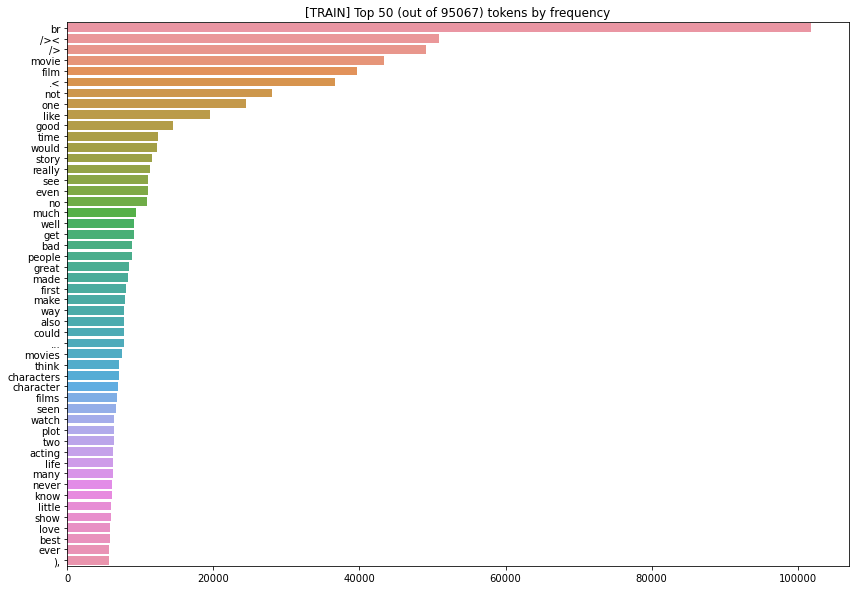

In [17]:
# Train
df_train_tokens_counter = tokens_counter(
    corpus                = df_train["review"],
    tokenizer             = None,
    filter_punctuation    = True,
    filter_stopwords      = True,
    whitelist             = STOPWORDS_WHITELIST,
)

topk = 50
tokens, freqs = [], []
for token, freq in df_train_tokens_counter.most_common()[:topk]:
    tokens.append(token)
    freqs.append(freq)

plot_utils.plot_tokens_by_freq(
    tokens    = tokens,
    freqs     = freqs,
    figsize   = (14, 10),
    title     = f"[TRAIN] Top {topk} (out of {len(df_train_tokens_counter)}) tokens by frequency"
)

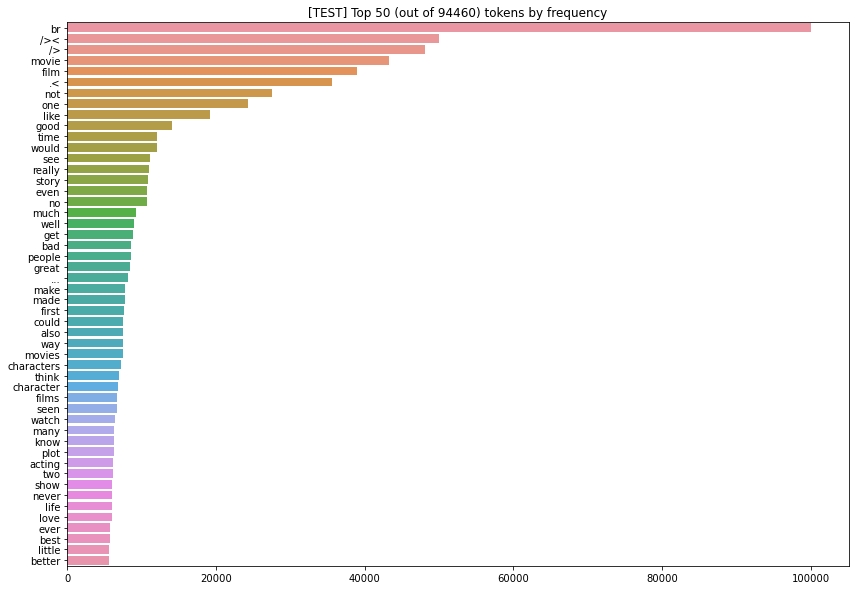

In [18]:
# Test
df_test_tokens_by_freq = tokens_counter(
    corpus                = df_test["review"],
    tokenizer             = None,
    filter_punctuation    = True,
    filter_stopwords      = True,
    whitelist             = STOPWORDS_WHITELIST,
)

topk = 50
tokens, freqs = [], []
for token, freq in df_test_tokens_by_freq.most_common()[:topk]:
    tokens.append(token)
    freqs.append(freq)

plot_utils.plot_tokens_by_freq(
    tokens    = tokens,
    freqs     = freqs,
    figsize   = (14, 10),
    title     = f"[TEST] Top {topk} (out of {len(df_test_tokens_by_freq)}) tokens by frequency"
)

EXPLORATION ANALYSIS
- Dataset is balanced - both train and test sets' reviews have 12.5k positive & negative labels.
- Dataset has a logarithmic token number distribution, and is balanced between positive & negative labels.
- Dataset contains redundant words and html syntaxes.

## Explore pre-processed reviews

In [19]:
# Word cloud (top 1000)
input_col         = "preprocessed_text"
df_train_wc       = plot_utils.gen_wordcloud(text=' '.join(df_train[input_col]), stopwords=nlp_dataset.STOPWORDS)
df_test_wc        = plot_utils.gen_wordcloud(text=' '.join(df_test[input_col]), stopwords=nlp_dataset.STOPWORDS)

df_train_pos_wc   = plot_utils.gen_wordcloud(text=' '.join(df_train_pos[input_col]), stopwords=nlp_dataset.STOPWORDS)
df_train_neg_wc   = plot_utils.gen_wordcloud(text=' '.join(df_train_neg[input_col]), stopwords=nlp_dataset.STOPWORDS)

df_test_pos_wc    = plot_utils.gen_wordcloud(text=' '.join(df_test_pos[input_col]), stopwords=nlp_dataset.STOPWORDS)
df_test_neg_wc    = plot_utils.gen_wordcloud(text=' '.join(df_test_neg[input_col]), stopwords=nlp_dataset.STOPWORDS)

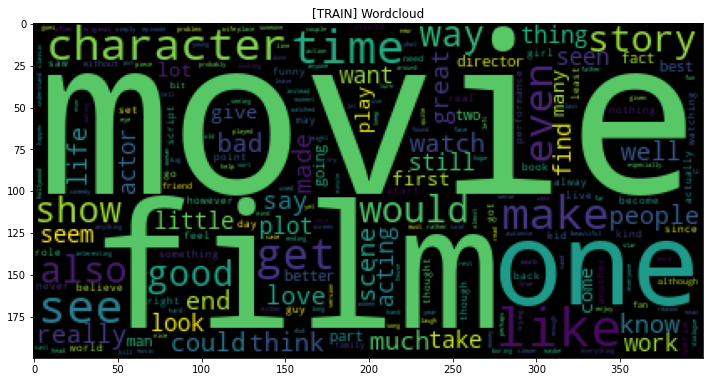

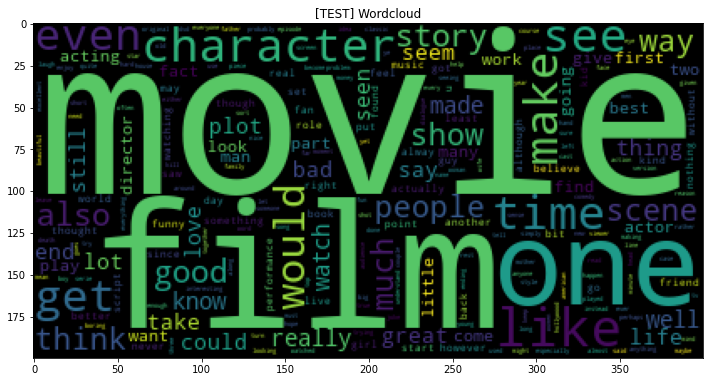

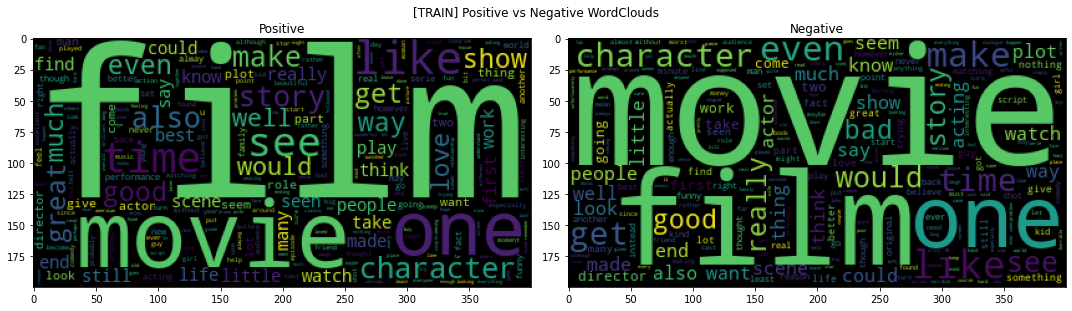

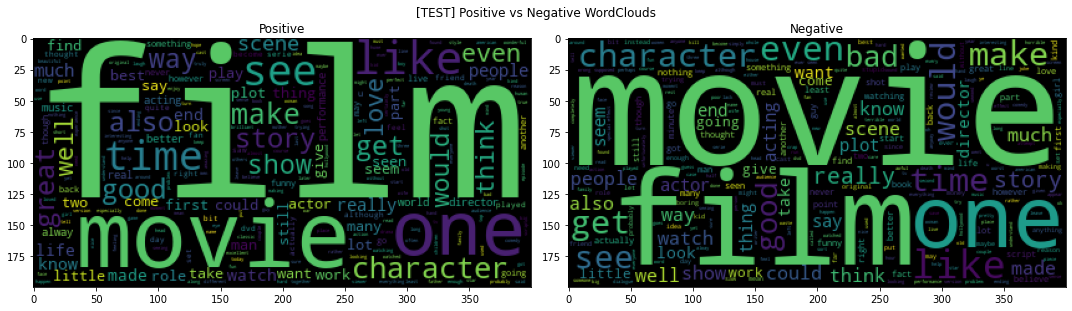

In [20]:
plot_utils.show_wordcloud(
    wc        = df_train_wc,
    title     = "[TRAIN] Wordcloud",
    figsize   = (12, 8)
)

plot_utils.show_wordcloud(
    wc        = df_test_wc,
    title     = "[TEST] Wordcloud",
    figsize   = (12, 8)
)

plot_utils.show_duo_wordcloud(
    wc1       = df_train_pos_wc,
    wc2       = df_train_neg_wc,
    title1    = "Positive",
    title2    = "Negative",
    suptitle  = "[TRAIN] Positive vs Negative WordClouds",
    figsize   = (15, 8)
)

plot_utils.show_duo_wordcloud(
    wc1       = df_test_pos_wc,
    wc2       = df_test_neg_wc,
    title1    = "Positive",
    title2    = "Negative",
    suptitle  = "[TEST] Positive vs Negative WordClouds",
    figsize   = (15, 8)
)

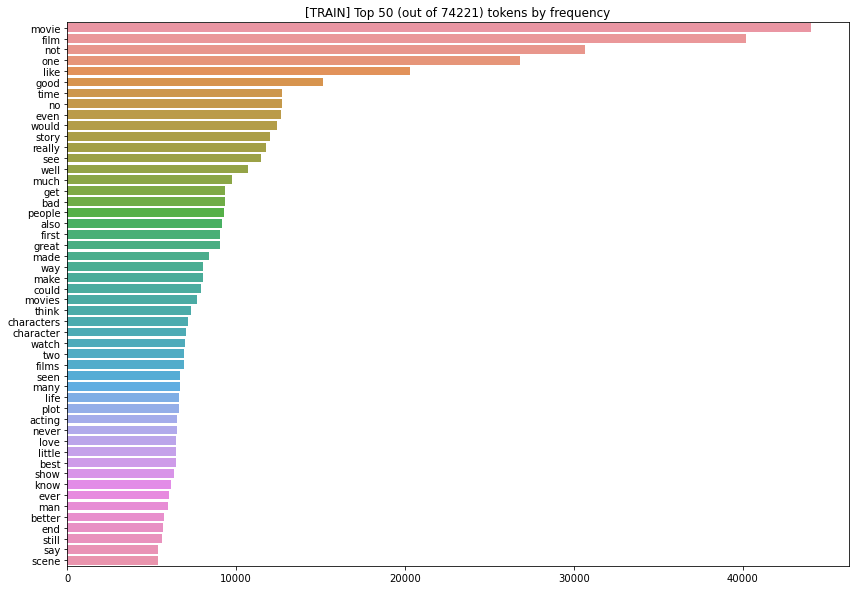

In [21]:
# Train
df_train_tokens_counter = tokens_counter(
    corpus                = df_train["preprocessed_text"],
    tokenizer             = None,
    filter_punctuation    = True,
    filter_stopwords      = True,
    whitelist             = STOPWORDS_WHITELIST,
)

topk = 50
tokens, freqs = [], []
for token, freq in df_train_tokens_counter.most_common()[:topk]:
    tokens.append(token)
    freqs.append(freq)

plot_utils.plot_tokens_by_freq(
    tokens    = tokens,
    freqs     = freqs,
    figsize   = (14, 10),
    title     = f"[TRAIN] Top {topk} (out of {len(df_train_tokens_counter)}) tokens by frequency"
)

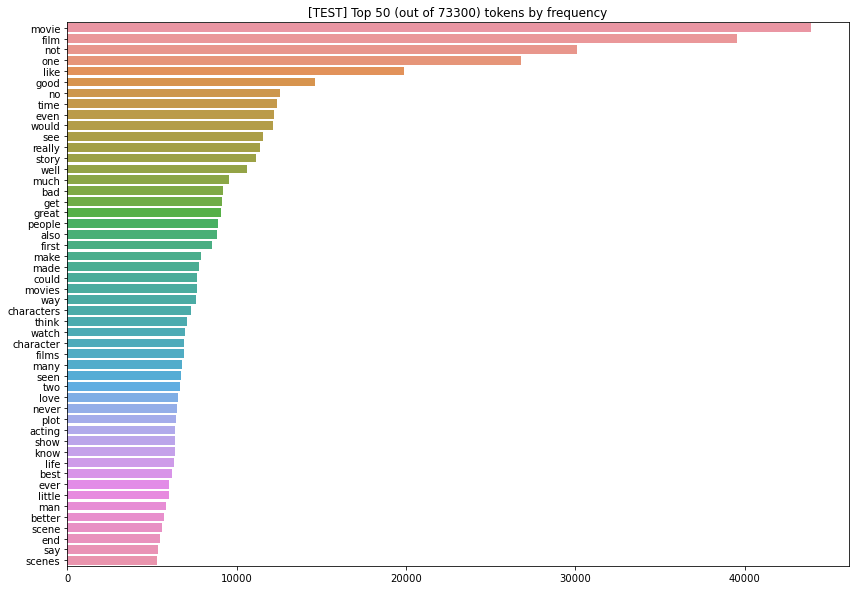

In [22]:
# Test
df_test_tokens_by_freq = tokens_counter(
    corpus                = df_test["preprocessed_text"],
    tokenizer             = None,
    filter_punctuation    = True,
    filter_stopwords      = True,
    whitelist             = STOPWORDS_WHITELIST,
)

topk = 50
tokens, freqs = [], []
for token, freq in df_test_tokens_by_freq.most_common()[:topk]:
    tokens.append(token)
    freqs.append(freq)

plot_utils.plot_tokens_by_freq(
    tokens    = tokens,
    freqs     = freqs,
    figsize   = (14, 10),
    title     = f"[TEST] Top {topk} (out of {len(df_test_tokens_by_freq)}) tokens by frequency"
)

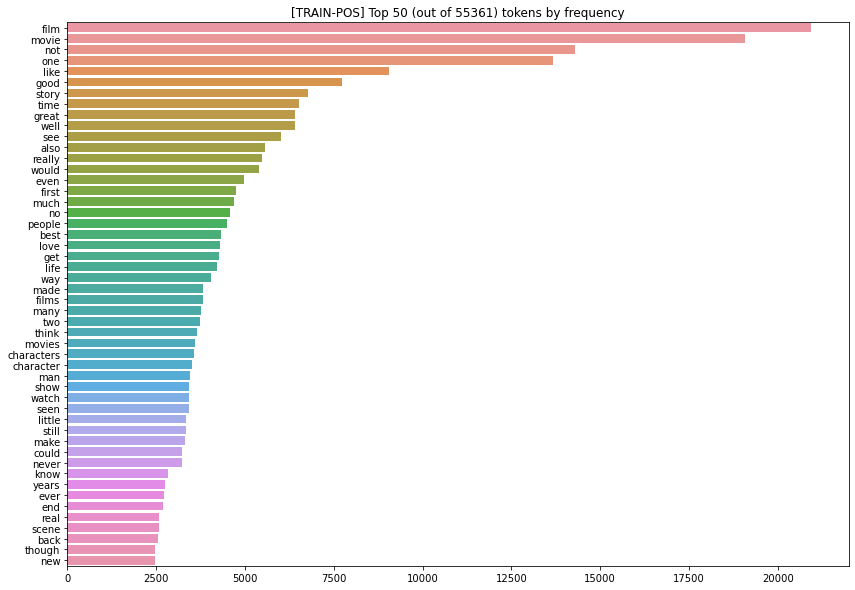

In [23]:
# Train (Positive)
df_train_tokens_counter = tokens_counter(
    corpus                = df_train_pos["preprocessed_text"],
    tokenizer             = None,
    filter_punctuation    = True,
    filter_stopwords      = True,
    whitelist             = STOPWORDS_WHITELIST,
)

topk = 50
tokens, freqs = [], []
for token, freq in df_train_tokens_counter.most_common()[:topk]:
    tokens.append(token)
    freqs.append(freq)

plot_utils.plot_tokens_by_freq(
    tokens    = tokens,
    freqs     = freqs,
    figsize   = (14, 10),
    title     = f"[TRAIN-POS] Top {topk} (out of {len(df_train_tokens_counter)}) tokens by frequency"
)

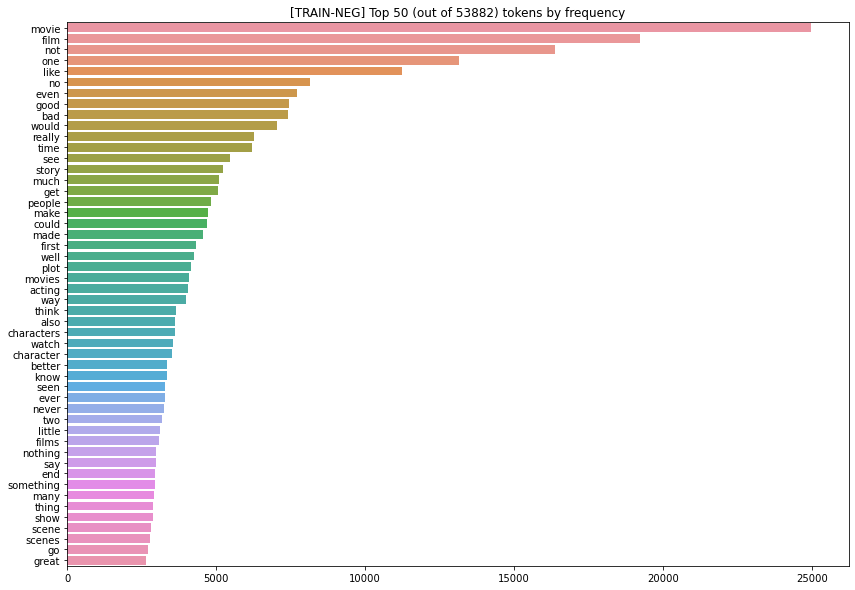

In [24]:
# Train (Negative)
df_train_tokens_counter = tokens_counter(
    corpus                = df_train_neg["preprocessed_text"],
    tokenizer             = None,
    filter_punctuation    = True,
    filter_stopwords      = True,
    whitelist             = STOPWORDS_WHITELIST,
)

topk = 50
tokens, freqs = [], []
for token, freq in df_train_tokens_counter.most_common()[:topk]:
    tokens.append(token)
    freqs.append(freq)

plot_utils.plot_tokens_by_freq(
    tokens    = tokens,
    freqs     = freqs,
    figsize   = (14, 10),
    title     = f"[TRAIN-NEG] Top {topk} (out of {len(df_train_tokens_counter)}) tokens by frequency"
)

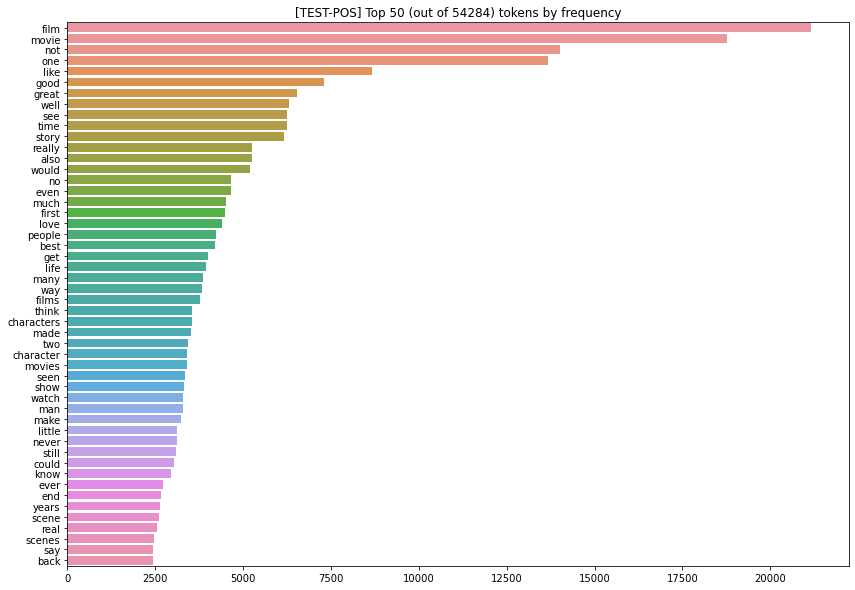

In [25]:
# Test (Positive)
df_test_tokens_by_freq = tokens_counter(
    corpus                = df_test_pos["preprocessed_text"],
    tokenizer             = None,
    filter_punctuation    = True,
    filter_stopwords      = True,
    whitelist             = STOPWORDS_WHITELIST,
)

topk = 50
tokens, freqs = [], []
for token, freq in df_test_tokens_by_freq.most_common()[:topk]:
    tokens.append(token)
    freqs.append(freq)

plot_utils.plot_tokens_by_freq(
    tokens    = tokens,
    freqs     = freqs,
    figsize   = (14, 10),
    title     = f"[TEST-POS] Top {topk} (out of {len(df_test_tokens_by_freq)}) tokens by frequency"
)

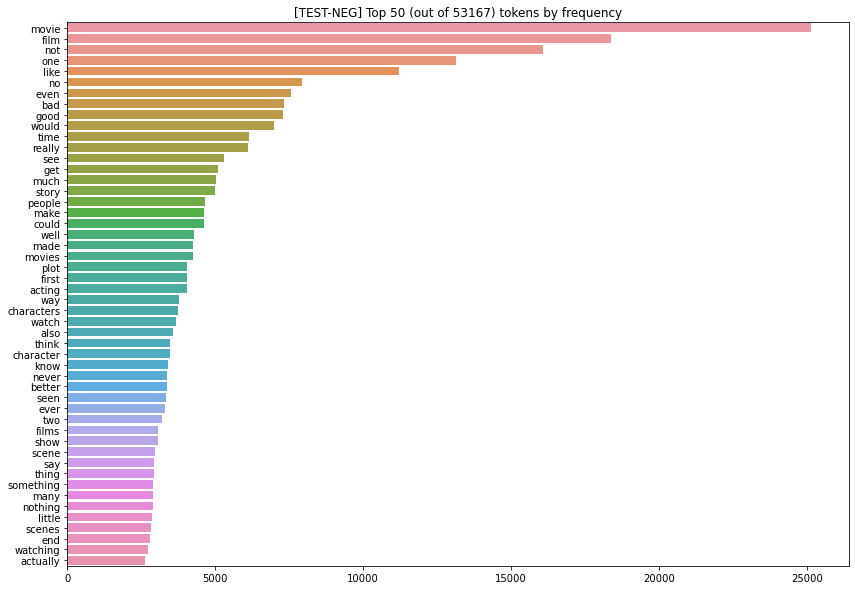

In [26]:
# Test (Negative)
df_test_tokens_by_freq = tokens_counter(
    corpus                = df_test_neg["preprocessed_text"],
    tokenizer             = None,
    filter_punctuation    = True,
    filter_stopwords      = True,
    whitelist             = STOPWORDS_WHITELIST,
)

topk = 50
tokens, freqs = [], []
for token, freq in df_test_tokens_by_freq.most_common()[:topk]:
    tokens.append(token)
    freqs.append(freq)

plot_utils.plot_tokens_by_freq(
    tokens    = tokens,
    freqs     = freqs,
    figsize   = (14, 10),
    title     = f"[TEST-NEG] Top {topk} (out of {len(df_test_tokens_by_freq)}) tokens by frequency"
)